In [55]:
import os
import numpy as np; np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
from plotly import offline
from sklearn.externals import joblib as jb

offline.init_notebook_mode(connected=True)

In [56]:
files = ['august.csv', 'september.csv', 'october.csv'] 
PATH ='../data/private/csv/fam/'

df = [pd.read_csv(os.path.join(PATH, file)) 
      for file in files]
df = pd.concat(df, sort=False)

query = '(month == 8 and day >= 27) or (month == 9) or (month == 10 and day <= 7)'
df = df.query(query)
df.head()

,time,sysclass,lat,lon,dir,vel,size,ttyyyxx1,ttyyyxx2,ttyyyxx3,...,maxz,meanvil,ttvil,meanprec,maxprec,year,month,day,hour,minute
12871,0.0,0.0,-2.75,-58.57,-999.0,0.0,13.0,0.0,0.0,0.0,...,22.28,0.18,2.31,0.97,1.18,2014,8,27,2,24
12872,0.2,1.0,-2.73,-58.57,0.0,11.1,30.0,0.0,0.0,0.0,...,28.17,0.30,9.10,1.80,4.16,2014,8,27,2,24
12873,0.0,0.0,-2.73,-58.57,-999.0,0.0,21.0,0.0,0.0,0.0,...,23.01,0.18,3.76,1.02,1.32,2014,8,27,3,0
12874,0.2,1.0,-2.75,-58.57,180.0,11.1,13.0,0.0,0.0,0.0,...,22.28,0.18,2.28,0.97,1.09,2014,8,27,3,0
12875,0.0,0.0,-1.71,-59.63,-999.0,0.0,12.0,0.0,0.0,0.0,...,21.46,0.16,1.96,0.92,0.97,2014,8,27,3,48


In [59]:
query1 = 'ttyyyxx3 == 0'
query2 = '(ttyyyxx3 >= 1) and (ttyyyxx3 <= 10)'
query3 = '(ttyyyxx3 > 10)'

class1 = df.query(query1)
class2 = df.query(query2)
class3 = df.query(query3)

total1 = class1['ttyyyxx3'].count()
total2 = class2['ttyyyxx3'].count()
total3 = class3['ttyyyxx3'].count()

fig = go.Figure()
labels = ['Classe 1 - sem detecção de raios (0 raios)', 
          'Classe 2 - atividade moderada (de 1 a 10 raios detectados)', 
          'Classe 3 - atividade extrema (mais de 10 raios detectados)']
values = [total1, total2, total3]

colors = ['#140304', '#3C090C', '#DC1F2A']
fig.add_trace(
    go.Pie(labels=labels, values=values, hole=.5,
           marker=dict(colors=colors, 
                    line=dict(color='#A0A0A0', width=1)))
)

fig.update_layout(
    template='plotly_dark',
    title='Definição e distribuição das classes'
)

# offline.plot(fig, image_filename='definition-classes-fam', image='png', image_width=1000, image_height=600)
offline.iplot(fig)

In [60]:
columns = [
    'ttyyyxx3', 'label', 'riverfrac', 'convfrac', 'strafrac', 
    'maxz', 'ttvil', 'maxprec',
]

samples = 1
samples *=  100
samples = int((min(values)*samples)/100)

df1 = class1.sample(samples)
df2 = class2.sample(samples)
df3 = class3.sample(samples)

df1['label'] = 0
df2['label'] = 1
df3['label'] = 2

df_ = pd.concat([df1, df2, df3], sort=False).sample(samples*3)


fig = go.Figure()

a = df_[df_['label'] == 0][['ttvil']]
b = df_[df_['label'] == 1][['ttvil']]
c = df_[df_['label'] == 2][['ttvil']]

aa = df_[df_['label'] == 0][['maxz']]
bb = df_[df_['label'] == 1][['maxz']]
cc = df_[df_['label'] == 2][['maxz']]

fig.add_trace(
    go.Scatter(x=aa.values.ravel(), y=a.values.ravel(),
              mode='markers', name='Subconjunto sem detecção de raios', marker=dict(opacity=.2))
)
fig.add_trace(
    go.Scatter(x=bb.values.ravel(), y=b.values.ravel(),
              mode='markers', name='Subconjunto com atividade moderada de raios', marker=dict(opacity=.2))
)
fig.add_trace(
    go.Scatter(x=cc.values.ravel(), y=c.values.ravel(),
              mode='markers', name='Subconjunto com atividade extrema de raios', 
               marker=dict(opacity=.2, line=dict(color='yellow', width=1)))
)
fig.update_xaxes(title_text='Máxima precipitação (dBZ)')
fig.update_yaxes(title_text='VIL (kg m<sup>-2</sup>)')
fig.update_layout(
    template='plotly_dark',
    title='Disperção dos índices de ttvil e maxz das 3 classes'
)

# offline.plot(fig, image_filename='scatter-of-indexes-ttvilXmaxz-fam', image='png', image_width=1000, image_height=600)

offline.iplot(fig)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_[columns[2:]], \
                                                    df_[[columns[1]]], \
                                                    test_size=.2)
rf100 = RandomForestClassifier(n_estimators=500).fit(X_train, y_train.values.ravel())
y_pred = rf100.predict(X_test)

In [62]:
rf100.feature_importances_

array([0.08576544, 0.10144318, 0.10310059, 0.18838557, 0.33657666,
       0.18472856])

In [63]:
fi = rf100.feature_importances_*100
attrs = {}
for key, value in zip(columns[2:], fi):
    attrs[key] = value

labels = list(attrs.keys())
values = list(attrs.values())
colors = ['#DC1F2A', '#001427', '#708D81', '#F4D58D', '#02CC6D', 
         '#02C4EF', '#FAFF05', '#CD05FF', '#FF8205']

fig = go.Figure()
fig.add_trace(
    go.Bar(x=labels, y=values, text=['%.2f%%'%(float(x)) for x in values], 
           marker_color=colors, textposition='outside')  
)

# fig.update_traces(hoverinfo='label+percent', textfont_size=20, hole=.5,
#                   marker=dict(colors=colors, line=dict(color='#282828', width=2)))
fig.update_layout(
    template='plotly_dark',
    title="Uso dos atributos pela classificação da floresta aleatória",
    autosize=True,
#     margin=dict(t=210)
#     font=dict(size=20)
)

# offline.plot(fig, image_filename='attributes-use-by-random-forest500-fam', image='png')
offline.iplot(fig)

In [64]:
cm = confusion_matrix(y_test, y_pred)

tc1 = cm[0][0]
fc1 = cm[0][1]+cm[0][2]

tc2 = cm[1][1]
fc2 = cm[1][0]+cm[1][2]

tc3 = cm[2][2]
fc3 = cm[2][0]+cm[2][1]

accuracy = (tc1+tc2+tc3)/(tc1+fc1+tc2+fc2+tc3+fc3)
precisionc1 = (tc1)/(tc1+fc1)
precisionc2 = (tc2)/(tc2+fc2)
precisionc3 = (tc3)/(tc3+fc3)

fig = go.Figure()
labels = ['Acurácia', 'Precisão da classe 1', 
          'Precisão da classe 2', 'Precisão da classe 3']
values = ['%.2f'%(accuracy*100), '%.2f'%(precisionc1*100),
         '%.2f'%(precisionc2*100), '%.2f'%(precisionc3*100)]
colors = ['#C61D1D', '#30FF41', '#0090FF', '#F18F01']
fig.add_trace(
    go.Bar(y=labels, x=values, orientation='h', 
           text=['%.2f%%'%(float(x)) for x in values], 
           marker_color=colors,
           textposition='inside')
)


fig.update_layout(
    template='plotly_dark',
    title='Métricas da classificação com limite de 10 nós folhas',
)
# offline.plot(fig, image_filename='metrics-random-forest100-fam', image='png')
offline.iplot(fig)

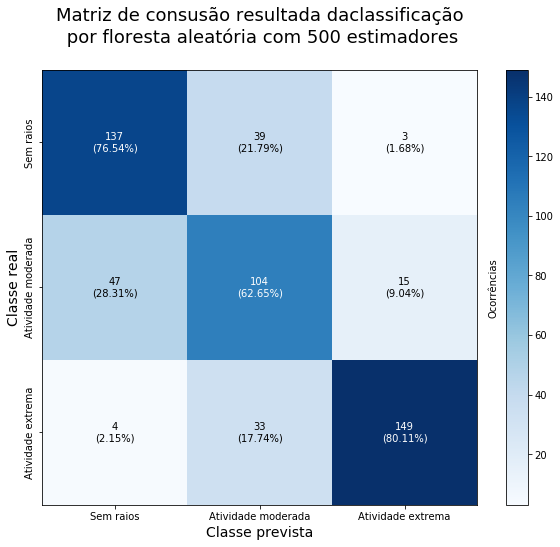

In [65]:
figsize = (15, 8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
cmap = plt.cm.Blues
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.4)

total_samples = cm.sum(axis=1)[:, np.newaxis]
normed_conf_mat = cm.astype('float') / total_samples
labels = ['Sem raios', 'Atividade moderada', 'Atividade extrema']
label_font = dict(fontweight='normal', size=14)
title_font = dict(fontweight='normal', size=18)

matshow = ax.matshow(cm, cmap=cmap)
cb = plt.colorbar(matshow, cax=cax, orientation='vertical')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cell_text = str(cm[i, j])
        cell_text += '\n(%.2f%%)' % (normed_conf_mat[i, j] * 100)
        ax.text(x=j,
                y=i,
                s=cell_text,
                va='center',
                ha='center',
                color="white" if normed_conf_mat[i, j] > 0.5 else "black")

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels, rotation=90, va='center')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     ax.set_title('Matriz de confusão para %d testes'%((n*2)*0.2), fontdict=title_font)
ax.set_xlabel('Classe prevista', fontdict=label_font)
ax.set_ylabel('Classe real', fontdict=label_font)
cb.ax.set_ylabel('Ocorrências', va='center', rotation=-270, labelpad=-60)
ax.set_title('Matriz de consusão resultada da\
classificação\n por floresta aleatória com 500 estimadores', fontdict=title_font)

plt.savefig('confusion_matrix_rf500.png', dpi=600, \
           bbox_inches='tight', transparent="False", pad_inches=0.1)
plt.show()

In [54]:
jb.dump(rf100, 'rf500-model.plk')

['rf500-model.plk']